# Equvariant Neural Networks

The previous chapter {doc}`data` discussed data transformation and network architecture decisions that can be made to make a neural network equivariant with respect to translation, rotation, and permutations. However, those ideas limit the expressibility of our networks and are constructed ad-hoc. Now we will take a more systematic approach to defining equivariances and prove that there is only one layer type that can preserve a given equivariance. The result of this section will be layers that can be equivariant with respect to any transform, even for more esoteric cases like points on a sphere or mirror operations. To achieve this, we will need tools from group theory, representation theory, harmonic analysis, and deep learning.


## Do you need equivariance?

Before we get too far, let me first try to talk you out of equivariant networks. The math required is advanced, especially because the theory of these is still in flux. There are three papers in the last two years that propose a general theory for equivariant networks and they each take a different approach. It is also easy to make mistakes in implementations due to the complexity of the methods. You also must do implementations (as of 2020) because there are no efficient general implementations for equivariant networks. You will also find that equivariant networks do not beat state of the art models on many of the tasks they're design for. Training and testing augmentation are powerful methods for many problems that are easy to implement. You can also do data transformations or specific parameter sharing to avoid equivariant networks. So why would you study this chapter? I think these ideas are important and incorporating the equivariant layers into other network architectures (Dimenet?) can dramatically reduce parameter numbers and training efficiency.



### Outline

We have to lay some mathematical foundations before we can grasp the equations and details of equivariant networks. We'll start with a brief overview of group theory so we can define the principle of equivariance generally. Then we'll visit representation theory to see how to encode groups into matrices. Then we'll show how any equivariance can be enforced in a neural network via a generalization of convolutions. Then we'll see how these convolutions can be more easily represented using the generalization of Fourier transforms. Finally, we'll see some of the special details when looking at equivariances of permutations. Throughout this chapter we'll see three examples that capture some of the different settings. Remember, that I am a chemical engineer so that some of this chapter will probably have reckless math, incomplete definitions, and implied assumptions about functions (e.g., smooth, integrable). 

## Group Theory

A group is a general object in mathematics. A group is a set of elements that can be combined in a binary operation whose output is another member of the group. The most common example are the integers. If you combine two integers in a binary operations, the output is another integer. Of course, it depends on the operation ($1 \div 2$ does not give an integer), so specifically consider addition. Integers are not the example we care about though, we're interested in groups of **transformations** that move points. Operations like rotation, scaling, mirroring, or translating. As you read about groups here, remember that the elements of the groups are *not* numbers or points. The group elements are transformations that act on points. Notice I'm being a bit nebulous on what a point is for now. Let's first define a group: 

```{admonition} Group
A group $G$ is a set of elements (e.g., $\{a, b, c, i, e\}$) equipped with a binary operation ($ab = c$) whose output is another group element and the following conditions are satisfied:

1. **Closure** The output of the binary operation is always a member of the group
2. **Associativity** $(ab)c = a(bc)$
3. **Identity** There is a single identity element $e$ such that $ex = x \forall x \in G$
4. **Inverse** There exists one inverse element $i$ for each $x$ such that $xi = e$
```

This is quite a bit of nice structure. We always have an inverse available and applying the binary operations never accidentally leaves our group. One important property that is missing from this list is **commutativity**. In general, a group is not commutative so that $ab \neq ba$. If the group does have this extra property, we call the group **abelian**. Another detail is how big the set is. It can indeed be infinite, which is why the integers or all possible rotations of a sphere can be represented as a group. 

```{margin}
If you write two transformations $ab$, we always apply $b$ first and then $a$. This is important to remember for non-commutative groups (non-abelian). 
```

Let's introduce our three example groups that we'll refer to throughout this chapter. Use the tabs below to switch between them. 

```{tabbed} ⬡ Finite Group $Z_6$ 

The first group is about rotations of a hexagon {glue:}`hex-6`. Our basic group member will be rotating the hexagon enough to shift all the vertices: {glue:}`hex-0` $\rightarrow$ {glue:}`hex-1`. Notice I've colored the vertices and added a line so we can easily distinguish the orientation of the hexagon. Remember the hexagon, its colors, and if it is actually symmetry have nothing to do with the group. *The group elements are transformations we apply to the hexagon*.

Our group must contain our rotation transformation $r$ and the identity: $\{e, r\}$. This is not enough. This set is not closed: rotating twice $rr$ {glue:}`hex-0` $\rightarrow$ {glue:}`hex-1` $\rightarrow$ {glue:}`hex-2` gives a new group element $r^2$. To close the group we need to have $\{e, r, r^2, r^3, r^4, r^5\}$. Is this closed? Consider rotating twice and then five times $r^2r^5$ {glue:}`hex-0` $\rightarrow$ {glue:}`hex-2` $\rightarrow$ {glue:}`hex-1` You can see that this is the same as $r$, so $r^2r^5 = r$. What about the inverses element? The inverse of $r$ is $r^5$. $rr^5 = e$. You can indeed see that each element has an inverse ($e$ is its own inverse).

In general, we can write out the group as a multiplication table that conveys all group elements and defines the output of all binary outputs:

$$
\begin{array}{l|cccccr}
& e & r & r^2 & r^3 & r^4 & r^5\\
\hline
e & e & r & r^2 & r^3 & r^4 & r^5\\
r & r & r^2 & r^3 & r^4 & r^5 & e\\
r^2 & r^2 & r^3 & r^4 & r^5 & e & r\\
r^3 & r^3 & r^4 & r^5 & e & r & r^2\\
r^4 & r^4 & r^5 & e & r & r^2 & r^3\\
r^5 & r^5 & e & r & r^2 & r^3 & r^4\\
\end{array}
$$

You can also see that the group is abelian (commutative). For example, $rr^3 = r^3r$. This group is an example of a **cyclic group** and is isomorphic (same transofmrations, but operates on different objects) to integers modulo 6. Meaning, you could view rotation $r^n$ as operating on integers $(x + n) \textrm{mod} 6$. Cyclic groups are written as $Z_n$, so this group is $Z_6$. 

```

```{tabbed} ▩ Locally Compact $t+D_4$

The second group contains translation, 90° rotations, and  horizontal/vertical mirroring. We're now operating on $x,y$ points, so we're in $\mathbb{R}^2$. Let's ignore the translation for now and just consider mirroring ($s$) and rotation by 90° ($r$). What powers of $r$ and $s$ do we need to have a closed group? Considering rotations alone first, like last time we should only need up to $r^3$. Here are the rotations visually: {glue:}`quad-0-0`, {glue:}`quad-1-0`, {glue:}`quad-2-0`, {glue:}`quad-3-0` What about mirroring on horizontal/vertical? Mirroring along the horizontal axis: {glue}`quad-0-0` $\rightarrow$ {glue}`quad-2-1` is actually the same as rotating twice and then mirroring along the vertical. In fact, you only need to have mirroing along one axis. We'll choose the vertical axis by convention and denote that as $s$. Is this closed with $\{e, r, r^2, r^3, s\}$? No, since $r^2s$ {glue}`quad-0-0` $\rightarrow$ {glue}`quad-2-0` $\rightarrow$ {glue}`quad-2-1` is not an element. To close the group, we need $\{e, r, r^2, r^3, s, \}$ The multiplication table (which defines the elements too) is:

$$
\begin{array}{l|ccccr}
& e & r & r^2 & r^3 & s\\
\hline
e & e & r & r^2 & r^3 & s\\
r & r & r^2 & r^3 & e & s\\

\end{array}
$$

Our group (without translations) is called the dihedral 4 group and is denoted as $D_4$.

rotation + translation

Questions - Is it a point group (common origin?) or not because we allow translation. 

```

```{tabbed} ⚽ SO(3) Lie Group $SO(3)$



```

## Symmetry

We're now ready to prepare a more general definition of symmetry. 

```{tabbed} ⬡ Finite Group $C_6$ 

Hexagon rotation, no trans

```

```{tabbed} ▩ Locally Compact $D_4$

rotation + translation

Questions - Is it a point group (common origin?) or not because we allow translation. 

```

```{tabbed} ⚽ SO(3) Lie Group $SO(3)$



```

Intro video: https://www.youtube.com/watch?v=mH0oCDa74tE

Convolutions are only way to go: https://arxiv.org/abs/1806.09231

homogenuous -> you can reach any point with a group. 

best theory (I think) https://arxiv.org/pdf/1802.03690.pdf
similar but with fiber bundles/cosets -> https://arxiv.org/pdf/1811.02017.pdf

induced action -> group element acting on function. Induced space -> space of that (?)


some people say covariant -> group element on input != group element on output

Let's start with G-CNN which I'm having trouble understanding:

Presentation on locally compact groups -> https://galton.uchicago.edu/mart/slides/Kondor_Fourier.pdf

commutative -> representations are complex scalars (FFT is easy). Called LCA (locally compact abelian)     

$$
[f * \psi](g) = \frac{1}{|G|}\sum_{x}
$$

## Outline

Maybe start with finite group, conclude with G-CNN 

Then move to compact groups

then move to permutations

1. Finite Groups and use molecular structure example  https://en.wikipedia.org/wiki/Molecular_symmetry
2. Representations, irreps -- finding them https://www.jstor.org/stable/2004848?seq=1#metadata_info_tab_contents, https://en.wikipedia.org/wiki/Group_representation, character tables - https://www.chem.uci.edu/~lawm/10-2.pdf package: https://gemmi.readthedocs.io/en/latest/symmetry.html#operations - does not include permutation symmetry
3. functions on them -> an image is a function, molecular coordiates are a function, we're learning a function (?)Does that mean layers are operators? Guess so
4. define equivariance 
5. equivariant neuron - Show group CNN first, then Kondor construction
6. examples
7. survey of field

G-CNN - easy for discrete groups. http://proceedings.mlr.press/v48/cohenc16.pdf
could use for all point groups too - depends on number of group elements. 

DeepSets - https://proceedings.neurips.cc/paper/2017/file/f22e4747da1aa27e363d86d40ff442fe-Paper.pdf
equivariant strategy for networks. This defines them using convolutions - https://arxiv.org/pdf/2004.03990.pdf. Here is the hierarchical variant: https://proceedings.neurips.cc//paper_files/paper/2020/hash/9efb1a59d7b58e69996cf0e32cb71098-Abstract.html - they use MLPs with weight sharing. Is that equivalent to group convolutions? Average over groups strategy -> equation 44 in https://arxiv.org/pdf/2004.05154.pdf. Maybe average over groups = convolution (aka correlation). Yes, it does. However, you do not have to average. You can keep each independent component. The averaging comes from the pooling. Averaging moves to a coset (removing a part of the group) and moves you to a quoteint space (see 6.5 in G-CNN ppaer). 

Icosohedron convs enforce weight sharing in their convolutions - https://arxiv.org/pdf/1902.04615.pdf

The Clepsh-Gordon approach doesn't use a convolution, but instead a product in spectral (fourier) space. 

Fiber bundles and fields intro. Proves convolutions are only way to do it. 

https://arxiv.org/pdf/1811.02017.pdf

Notation - you can refer to the irreducible representations of SO3 (momentum numbers, l = ) as fragments

ok modern permutation invariant -> https://arxiv.org/pdf/2004.03990.pdf. Maybe not that interesting (second order permutations are interesting), but reconciles the locally compact groups being fourier convolutions with permutations. 

Can approximate convolutions with quadrature (MC integration) https://arxiv.org/pdf/2002.12880.pdf instead of using Fourier Space

**coset** a subgroup that is also a group (closed). Like translation in a roto-translational equivariant group.

We should keep the wreath products in mind though!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e1bc2', '#AAAAAA']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)

0 0


0 1


1 0


1 1


2 0


2 1


3 0


3 1


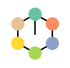

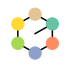

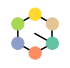

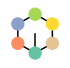

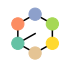

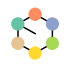

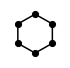

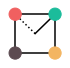

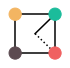

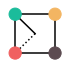

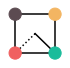

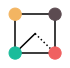

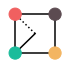

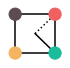

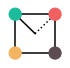

In [36]:
from myst_nb import glue

def hexico(rot):
    cmap = plt.get_cmap('Set2')        
    colors = [cmap(i / 6) for i in range(6)]
    points = np.array([(0,1), (0.5 * np.sqrt(3), 0.5), (0.5 * np.sqrt(3), -0.5), (0, -1), (-0.5 * np.sqrt(3), -0.5), (-0.5 * np.sqrt(3), 0.5)])
    # wrap the points
    index = [(i + rot) % 6 for i in range(6)]
    points = points[index]
    plt.figure(figsize=(1, 1))        
    if rot == 6:
        plt.scatter(points[:,0], points[:,1], marker='.', color='black', s=150)
    else:
        plt.scatter(points[:,0], points[:,1], marker='o', c=colors, s=150)
        plt.plot([0, points[0,0]], [0, points[0, 1]], color='black', zorder=0)    
        
    plt.plot(points[:, 0], points[:, 1], color='black', zorder=0)
    plt.plot([points[-1, 0], points[0, 0]],  [points[-1, 1], points[0, 1]], color='black', zorder=0)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1.4, 1.4)
    plt.ylim(-1.4, 1.4)    
    for s in plt.gca().spines.values():
        s.set_visible(False)
    glue(f'hex-{rot}', plt.gcf(), display=False)
for i in range(7):
    hexico(i)
    
def quad(rot, mirror):
    colors = color_cycle[:4]
    points = np.array([(1, 1), (-1, 1), (-1, -1), (1, -1)])
    # wrap the points
    index = [(i + rot) % 4 for i in range(4)]
    points = points[index]
    if mirror:
        points[:, (0,1)] = points[:, (1, 0)]
    plt.figure(figsize=(1, 1))        
    plt.scatter(points[:,0], points[:,1], marker='o', c=colors, s=150)
    plt.plot([0, points[0,0]], [0, points[0, 1]], color='black', zorder=0)    
        
    plt.plot(points[:, 0], points[:, 1], color='black', zorder=0)
    plt.plot([points[-1, 0], points[0, 0]],  [points[-1, 1], points[0, 1]], color='black', zorder=0)
    plt.plot([0, points[1, 0]],  [0, points[1, 1]], linestyle=':', color='black', zorder=0)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1.4, 1.4)
    plt.ylim(-1.4, 1.4)    
    for s in plt.gca().spines.values():
        s.set_visible(False)
    print(rot, mirror)
    glue(f'quad-{rot}-{mirror}', plt.gcf(), display=False)
for i in range(4):
    for j in range(2):
        quad(i, j)